# 1. Import Libraries

In [71]:
# Calculate number
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

# Handling Outlier
from feature_engine.outliers import Winsorizer

# Scikit-Learn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples

# Dimensionality Reduction using PCA
from sklearn.decomposition import PCA

# Model Saving
import pickle
import json

# Suppress All Warnings
import warnings
warnings.filterwarnings('ignore')

# 2. Data Loading

In [72]:
# Data Load
df_ori = pd.read_csv('data_clean.csv')

# Just in case there is original data
df = df_ori.copy()

In [73]:
# Show top 10 data
df.head(10)

,age,job,marital,education,has_credit,balance,housing_loan,loan,contact,day,month,duration,campaign,days_passed,previous,outcome_passed,subscribed
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,october,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,april,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,juny,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
5,35,management,single,tertiary,no,747,no,no,cellular,23,february,141,2,176,3,failure,no
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341,1,330,2,other,no
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,-1,0,unknown,no
8,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,-1,0,unknown,no
9,43,services,married,primary,no,-88,yes,yes,cellular,17,april,313,1,147,2,failure,no


In [74]:
# Show data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             4521 non-null   int64 
 1   job             4521 non-null   object
 2   marital         4521 non-null   object
 3   education       4521 non-null   object
 4   has_credit      4521 non-null   object
 5   balance         4521 non-null   int64 
 6   housing_loan    4521 non-null   object
 7   loan            4521 non-null   object
 8   contact         4521 non-null   object
 9   day             4521 non-null   int64 
 10  month           4521 non-null   object
 11  duration        4521 non-null   int64 
 12  campaign        4521 non-null   int64 
 13  days_passed     4521 non-null   int64 
 14  previous        4521 non-null   int64 
 15  outcome_passed  4521 non-null   object
 16  subscribed      4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


# 3. Exploratory Data Analysis (EDA)

# 4. Feature Engineering

In [75]:
df['subscribed'] = df['subscribed'].map({'no':0,'yes':1})

## 4.1 - Splitting Feature

In [76]:
# Splitting numeric columns and categorical columns

num_columns = df.select_dtypes(include=np.number).columns.tolist()
cat_columns = df.select_dtypes(include=['object']).columns.tolist()

df_num = df[num_columns]
df_cat = df[cat_columns]

print('Num Columns : ', num_columns)
print('Cat Columns : ', cat_columns)

Num Columns :  ['age', 'balance', 'day', 'duration', 'campaign', 'days_passed', 'previous', 'subscribed']
Cat Columns :  ['job', 'marital', 'education', 'has_credit', 'housing_loan', 'loan', 'contact', 'month', 'outcome_passed']


## 4.2 - Feature Scaling

In [77]:
# Feature scaling

scaler = StandardScaler()
df_num_scaled = scaler.fit_transform(df_num)

## 4.3 - PCA

Text(0, 0.5, 'Eigenvalues')

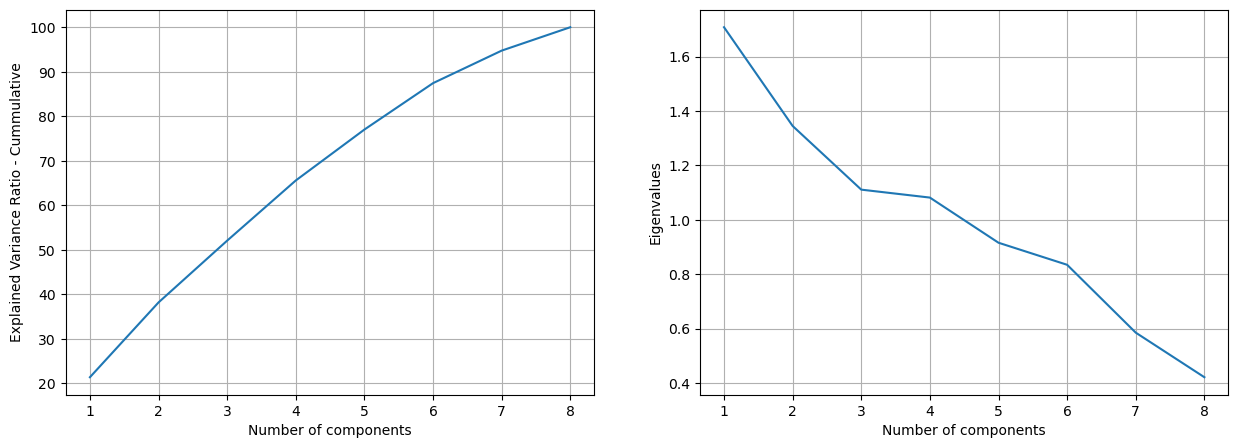

In [78]:
# Dimensionality Reduction using PCA

pca = PCA()
pca.fit(df_num_scaled)

# Plot the Cummulative of Explained Variance Ratio
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(range(1, 9), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio - Cummulative')

# Plot the Eigenvalues
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(range(1, 9), pca.explained_variance_ )
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')

In [79]:
# Check the number of features if we want to retain 95 % of the information

cumsum = np.cumsum(pca.explained_variance_ratio_)
num_features = np.argmax(cumsum >= 0.95) + 1
num_features

8

In [80]:
# Let's train the model with 95 % of the original dataset information

pca = PCA(n_components=3)
pca.fit(df_num_scaled)

df_num_scaled_pca = pca.transform(df_num_scaled)

## 4.4 - Merge Data

In [81]:
# Concate columns

df_final = np.concatenate([df_num_scaled_pca, df_cat], axis=1)
df_final = pd.DataFrame(df_final, columns=[['PCA1', 'PCA2', 'PCA3'] + cat_columns])
df_final = df_final.infer_objects()
df_final

,PCA1,PCA2,PCA3,job,marital,education,has_credit,housing_loan,loan,contact,month,outcome_passed
0,-0.700556,-0.478721,-0.072051,unemployed,married,primary,no,no,no,cellular,october,unknown
1,3.113356,-2.015259,0.019515,services,married,secondary,no,yes,yes,cellular,may,failure
2,1.809387,-1.459346,0.255980,management,single,tertiary,no,yes,no,cellular,april,failure
3,-0.430417,-0.318832,-0.692608,management,married,tertiary,no,yes,yes,unknown,juny,unknown
4,-0.181054,0.045702,-1.747574,blue-collar,married,secondary,no,yes,no,unknown,may,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
4516,-1.048127,0.166461,1.731495,services,married,secondary,no,yes,no,cellular,july,unknown
4517,-0.399145,-0.119300,-1.133607,self-employed,married,tertiary,yes,yes,yes,unknown,may,unknown
4518,-1.353293,-0.293714,1.250068,technician,married,secondary,no,no,no,cellular,august,unknown
4519,1.739010,-1.750173,0.281976,blue-collar,married,secondary,no,no,no,cellular,february,other


# 5. Model Definition

In [82]:
# Get the position of categorical columns

index_cat_columns = [df_final.columns.get_loc(col) for col in list(df_final.select_dtypes('object').columns)]

print('Categorical columns        : ', cat_columns)
print('Categorical columns index  : ', index_cat_columns)

Categorical columns        :  ['job', 'marital', 'education', 'has_credit', 'housing_loan', 'loan', 'contact', 'month', 'outcome_passed']
Categorical columns index  :  [3, 4, 5, 6, 7, 8, 9, 10, 11]


Cluster creation :  1
Cluster creation :  2
Cluster creation :  3
Cluster creation :  4
Cluster creation :  5
Cluster creation :  6


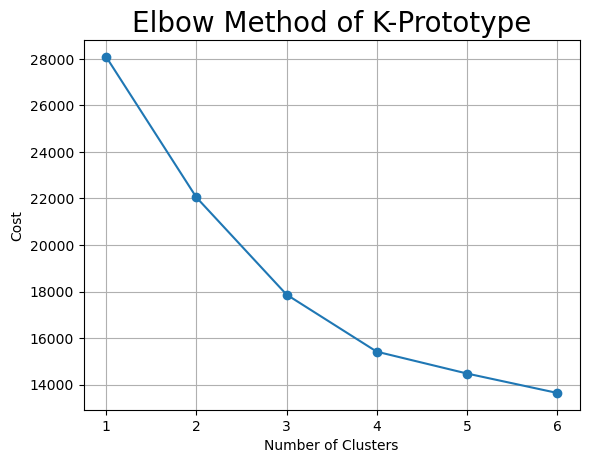

In [83]:
# Find the optimal number of clusters using Elbow Method

max_clusters = 6
cost = []
for k in range(1, max_clusters+1):
  kproto = KPrototypes(n_clusters=k, init='Huang', random_state=42, n_jobs=-1)
  kproto.fit_predict(df_final, categorical=index_cat_columns)
  cost.append(kproto.cost_)
  print('Cluster creation : ', k)

plt.plot(range(1, max_clusters+1), cost, marker ="o")
plt.grid()
plt.title('Elbow Method of K-Prototype', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.show()

# 6. Model Training

In [84]:
# Train with optimal number of clusters

kp = KPrototypes(n_clusters=2, random_state=42)
pred = kp.fit_predict(df_final, categorical=index_cat_columns)
pred

array([0, 1, 1, ..., 0, 1, 1], dtype=uint16)

In [85]:
# Insert clustering result into original dataset

df['cluster'] = pred
df

,age,job,marital,education,has_credit,balance,housing_loan,loan,contact,day,month,duration,campaign,days_passed,previous,outcome_passed,subscribed,cluster
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,october,79,1,-1,0,unknown,0,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,0,1
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,april,185,1,330,1,failure,0,1
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,juny,199,4,-1,0,unknown,0,0
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,july,329,5,-1,0,unknown,0,0
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,0,0
4518,57,technician,married,secondary,no,295,no,no,cellular,19,august,151,11,-1,0,unknown,0,0
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,february,129,4,211,3,other,0,1


# 7. Model Analysis

<Axes: >

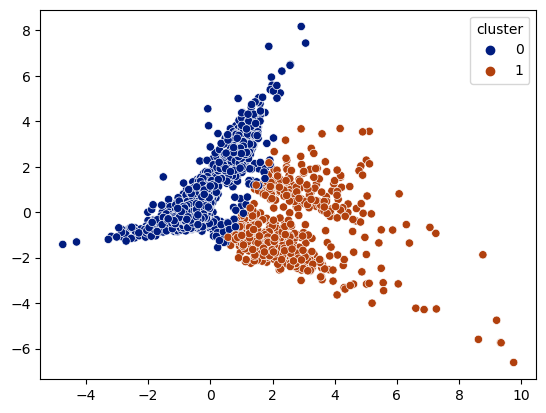

In [86]:
pca_2d = PCA(n_components=2)
pca_2d.fit(df_num_scaled)

df_scaled_pca_2d = pca_2d.fit_transform(df_num_scaled)

sns.scatterplot(x=df_scaled_pca_2d[:,0], y=df_scaled_pca_2d[:,1], hue=df['cluster'], palette='dark')

## 7.1 - Cluster 1

In [87]:
df[df['cluster']==0].describe()

,age,balance,day,duration,campaign,days_passed,previous,subscribed,cluster
count,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.0
mean,41.238845,1378.097638,16.258530,262.000000,2.936483,1.933858,0.034646,0.092126,0.0
std,10.531238,2993.338426,8.308383,262.731892,3.300025,19.038349,0.226510,0.289242,0.0
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000,0.000000,0.0
25%,33.000000,61.000000,9.000000,102.000000,1.000000,-1.000000,0.000000,0.000000,0.0
50%,40.000000,422.000000,17.000000,180.000000,2.000000,-1.000000,0.000000,0.000000,0.0
75%,49.000000,1415.000000,22.000000,326.000000,3.000000,-1.000000,0.000000,0.000000,0.0
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,192.000000,4.000000,1.000000,0.0


## 7.2 - Cluster 2

In [88]:
df[df['cluster']==1].describe()

,age,balance,day,duration,campaign,days_passed,previous,subscribed,cluster
count,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000,711.0
mean,40.801688,1661.440225,14.075949,274.471167,2.028129,242.499297,3.264416,0.239100,1.0
std,10.814117,3086.722267,7.662043,243.779221,1.564319,114.160461,3.029965,0.426834,0.0
min,20.000000,-1400.000000,1.000000,5.000000,1.000000,1.000000,1.000000,0.000000,1.0
25%,33.000000,139.000000,7.000000,119.000000,1.000000,168.500000,1.000000,0.000000,1.0
50%,38.000000,625.000000,14.000000,206.000000,1.000000,231.000000,2.000000,0.000000,1.0
75%,47.000000,1687.500000,19.000000,339.000000,2.000000,338.500000,4.000000,0.000000,1.0
max,83.000000,26306.000000,31.000000,1579.000000,11.000000,871.000000,25.000000,1.000000,1.0
